In [1]:
import pandas as pd 
import geopandas as gpd
from typing import Optional

import os
from sklearn.preprocessing import StandardScaler

---

In [2]:
BASIN_ID = 3033
BASE_DATA_DIR = "/Users/cooper/Desktop/CAMELS-CH/data/timeseries"
OBSERVATION_SUBDIR = "observation_based"

In [3]:
def get_data_path(basin_id: int = BASIN_ID) -> Optional[str]:
    """
    Constructs path to CAMELS-CH observation data file.

    Args:
        basin_id: ID of the basin to load
    Returns:
        Full path to data file if exists, None otherwise
    """
    data_directory = os.path.join(BASE_DATA_DIR, OBSERVATION_SUBDIR)
    data_file = f"CAMELS_CH_obs_based_{basin_id}.csv"
    path_to_data = os.path.join(data_directory, data_file)

    return path_to_data if os.path.exists(path_to_data) else None


def preprocess_streamflow_data(path_to_data: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    streamflow_timeseries = pd.read_csv(path_to_data, index_col=0, parse_dates=True)
    streamflow_timeseries = streamflow_timeseries.dropna(subset=["discharge_spec(mm/d)"])
    
    target = streamflow_timeseries["discharge_spec(mm/d)"]
    covariates = streamflow_timeseries[[
        "precipitation(mm/d)",
        "temperature_min(degC)",
        "temperature_mean(degC)",
        "temperature_max(degC)",
    ]]

    # Create scalers once
    covariate_scaler = StandardScaler()
    target_scaler = StandardScaler()

    covariates_scaled = pd.DataFrame(
        covariate_scaler.fit_transform(covariates),
        index=covariates.index,
        columns=covariates.columns,
    )

    target_scaled = pd.Series(
        target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten(),
        index=target.index,
        name=target.name,
    )
    return covariates_scaled, target_scaled, target_scaler  # Return scaler for inverse transform if needed

path_to_data = get_data_path()
covariates, target, target_scaler = preprocess_streamflow_data(path_to_data)

In [2]:
target.head()

NameError: name 'target' is not defined

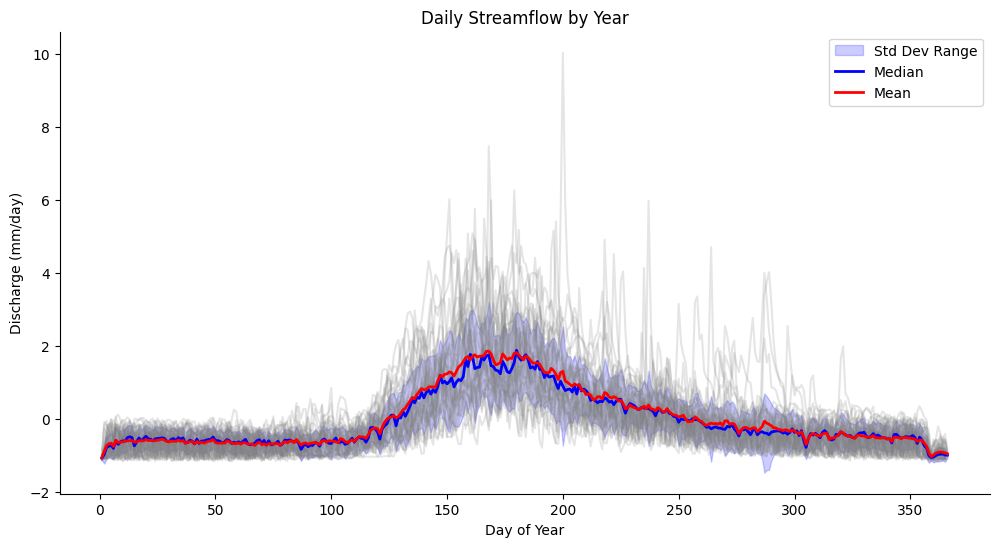

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

target_doy = target.copy()
target_doy.index = target_doy.index.dayofyear

# Calculate statistics by day of year
stats = target_doy.groupby(target_doy.index).agg(["median", "std", "mean"])
median_flow = stats["median"]
std_flow = stats["std"]
mean_flow = stats["mean"]

plt.figure(figsize=(12, 6))

# Plot individual years
for year in target.index.year.unique():
    year_data = target[target.index.year == year]
    year_data.index = year_data.index.dayofyear
    plt.plot(year_data, color="gray", alpha=0.2, label="_nolegend_")

# Plot std dev range
plt.fill_between(
    median_flow.index,
    median_flow - std_flow,
    median_flow + std_flow,
    color="blue",
    alpha=0.2,
    label="Std Dev Range",
)

# Plot median
plt.plot(median_flow, color="blue", linewidth=2, label="Median")

# Plot mean
plt.plot(mean_flow, color="red", linewidth=2, label="Mean")

plt.title("Daily Streamflow by Year")
plt.xlabel("Day of Year")
plt.ylabel("Discharge (mm/day)")
plt.legend()
sns.despine()
plt.show()

In [6]:
target_doy

date
1     -1.063886
2     -0.921795
3     -0.962393
4     -1.048929
5     -0.864104
         ...   
361   -0.547873
362   -0.196920
363   -0.391359
364   -1.001387
365   -1.079377
Name: discharge_spec(mm/d), Length: 13514, dtype: float64